In [5]:
### turn compareAlphas df into a json style dataframe
### parent data entries will contain alpha value, prediction,
### and list of selected features. actually lets grab the coeffs
### similar to histogram generating script

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
#grab our checkName code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import salty

In [98]:
desc[0][5]

-0.016918314631701663

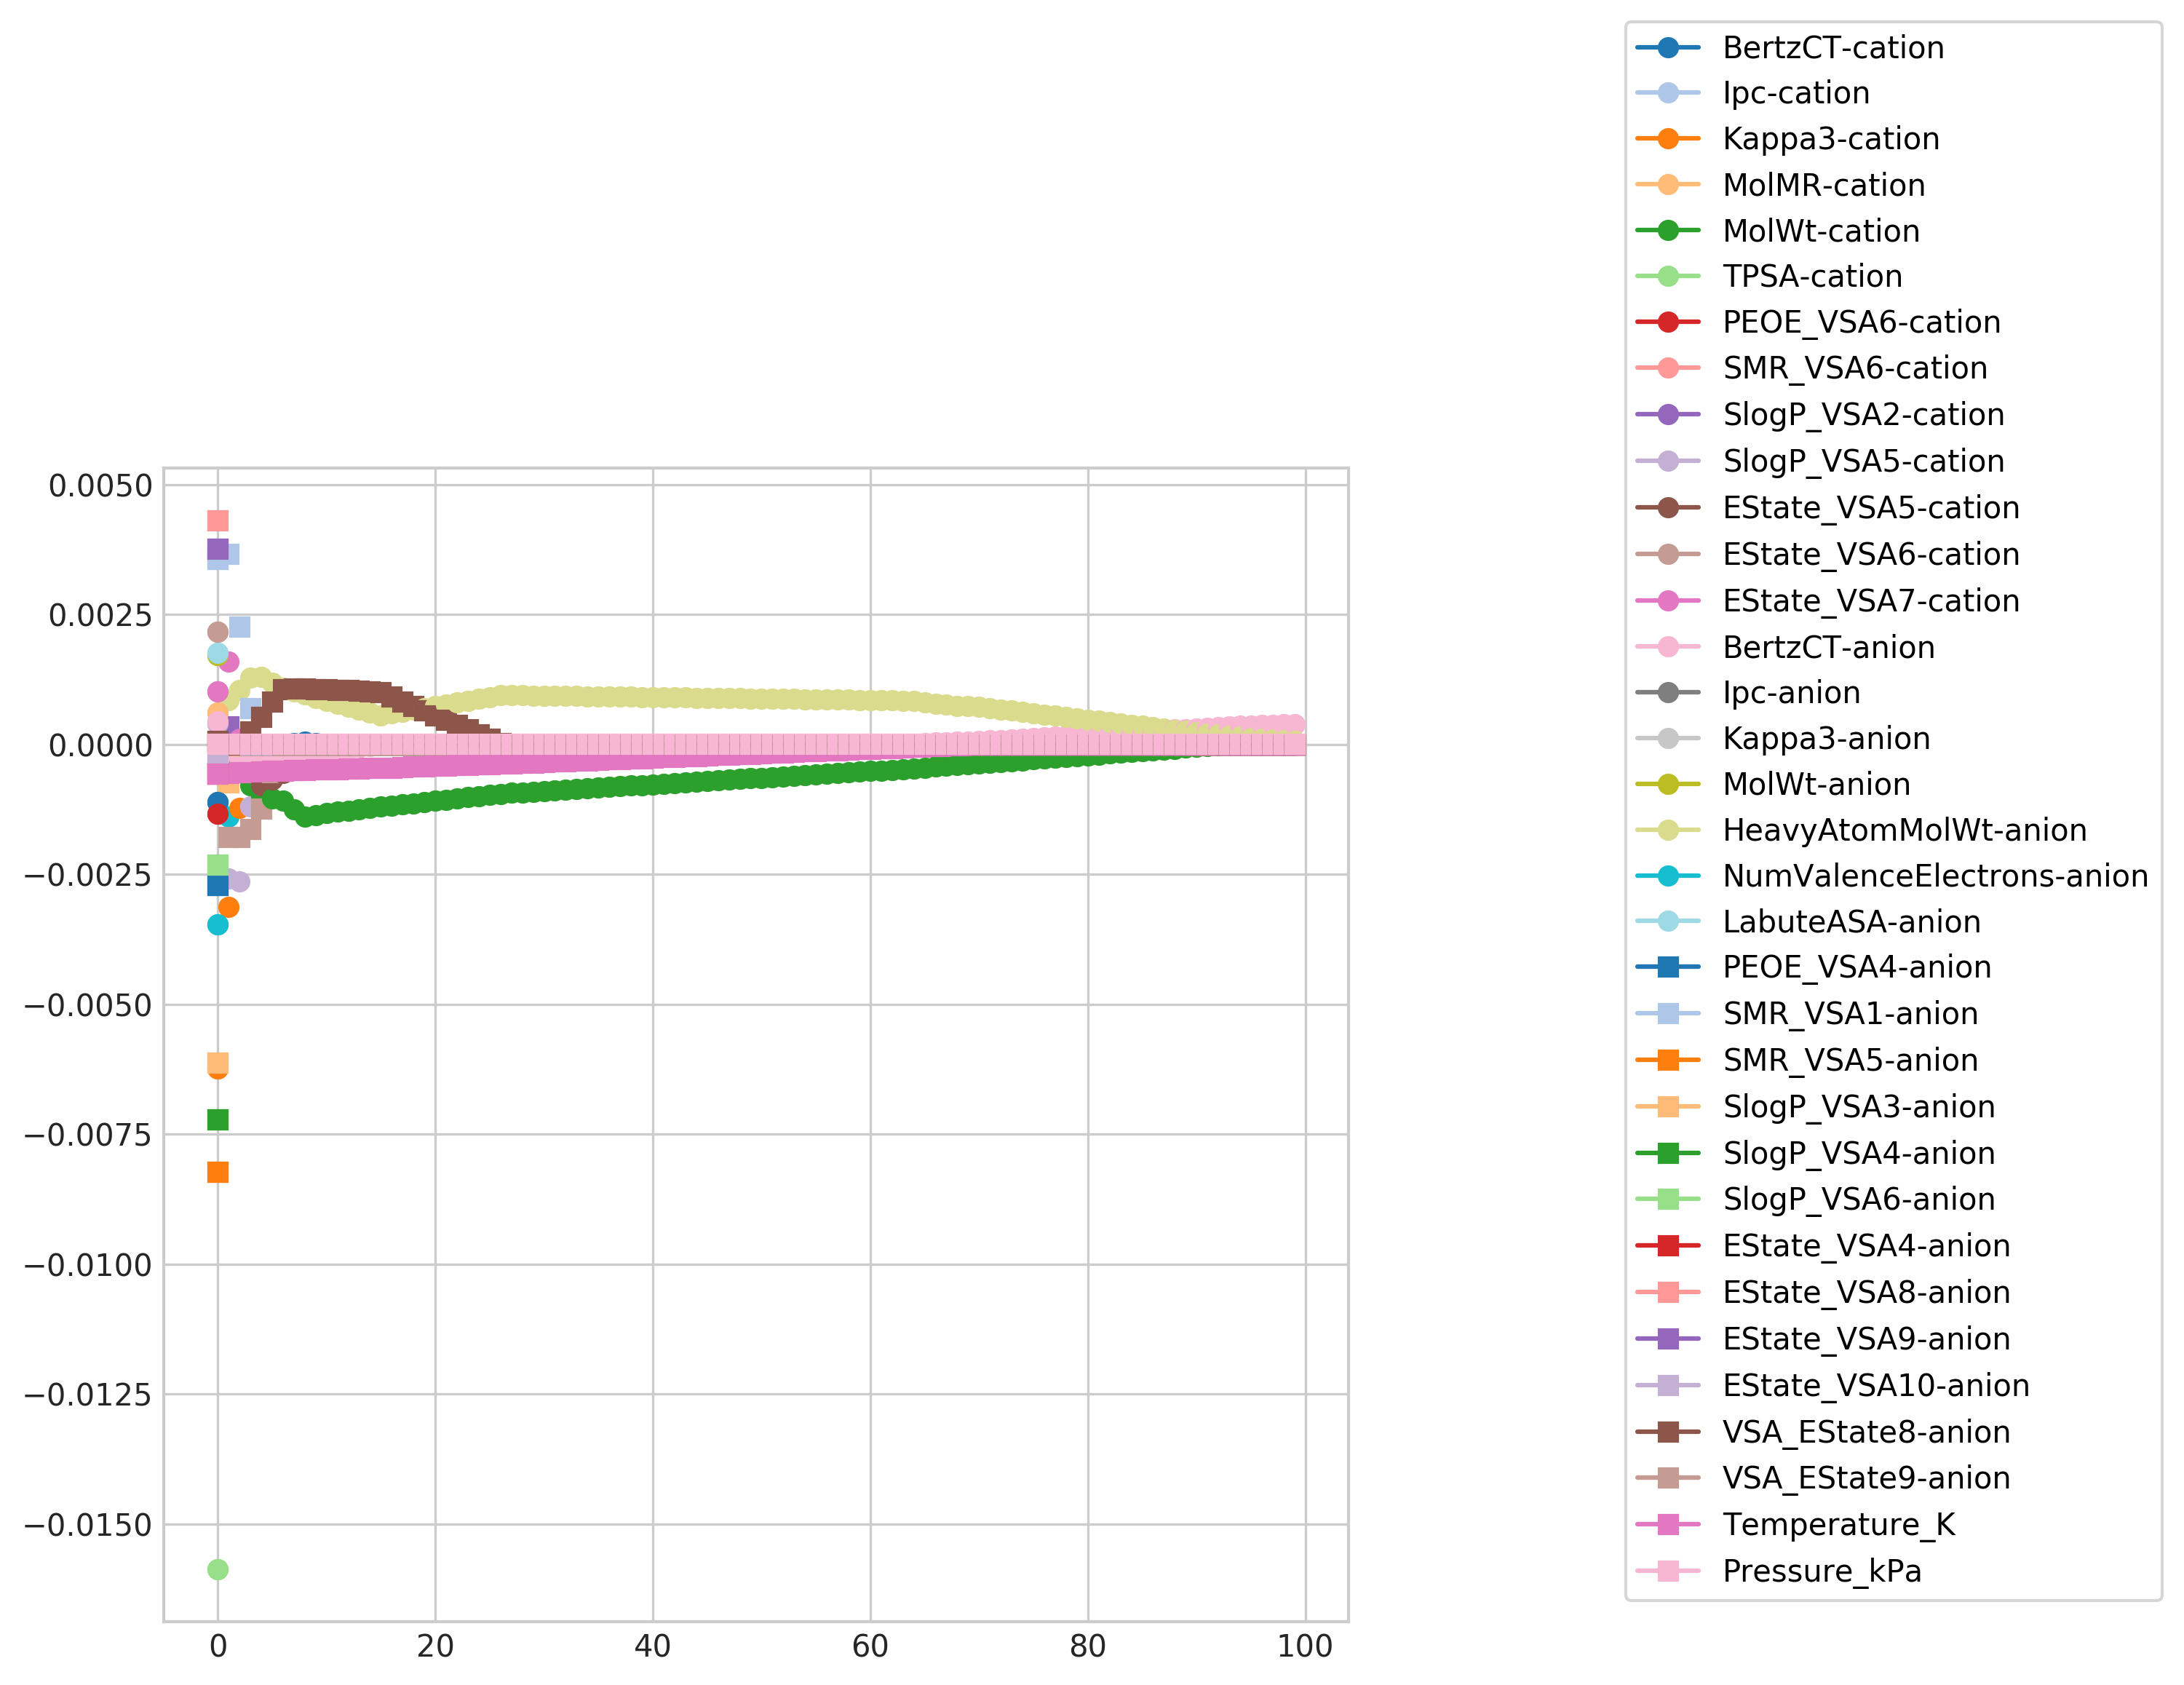

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(7,7), dpi=300)
    ax2 = fig.add_subplot(111)
    for j in range(len(desc)):
        for i in range(len(desc[0])):
            if i < 20:
                ax2.plot(j, desc[j][i], c=tableau20[i], marker='o')
            else:
                ax2.plot(j, desc[j][i], c=tableau20[i-20], marker='s')
    for i in range(len(desc[0])):
        if i < 20:
            ax2.plot(desc[0][i], label=cols[i], c=tableau20[i], marker='o')
        else:
            ax2.plot(desc[0][i], label=cols[i], c=tableau20[i-20], marker='s')
plt.legend(bbox_to_anchor=(1.7,1.4))
# plt.ylim(-0.005,0.005)

In [6]:
####Create dataset according to LASSO selected features
select_score = np.load("LASSOSelectionScoresAllSalts.npy")
select_deslist = np.load("LASSOSelectionListAllSalts.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
avg_selected_features=34
df = df.iloc[:avg_selected_features]

datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
datadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 
# datadf = datadf.loc[datadf["NAME_CAT"] != "1-ethyl-3-methylimidazolium"] #create subset

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
saltlist = datadf["salt_name"]        
datadf = datadf.drop("salt_name",1)

to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
to_add.append("Density_kg/m")
cols = [col for col in datadf.columns if col in to_add]
df = datadf[cols]

df, alphas, desc, mse = salty.compareAlphas(df, saltlist, target="Density_kg/m", alpha_array=np.arange(0,1,1e-2))

Job will perform 100 tests for lambda


/Users/wesleybeckner/Dropbox/Python/py2/salty/salty/salty.py:57: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train,Y_train)


Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % complete
Job complete


In [4]:
for i in range(10):
    
    ###Train the LASSO model
    model = Lasso(alpha=0.001,tol=1e-10,max_iter=2000)
    model.fit(X_train,Y_train)

    ###Check what features are selected
    i=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            i+=1
    avg_size.append(i)
    desSelected.append(model.coef_)
    
    ###Calculate the test set MSE
    Y_hat =model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
print(np.average(avg_size))
print(np.average(test_MSE_array))
select_score=[]
select_deslist=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])

/Users/wesleybeckner/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


34.0
0.000241324494419


In [80]:
pd.DataFrame.to_csv(df, path_or_buf='../salty/data/d3_web_data.csv', index=False)

In [1]:
from __future__ import print_function
import pandas as pd
import os
import sys
import matplotlib.pylab as plt
import numpy as np
import itertools as it
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy.random import randint
import numpy.linalg as LINA
from sklearn.preprocessing import StandardScaler
def compareAlphas(datadf, saltlist, target, alpha_array=np.arange(1,0,-1e-1), SSF=0.5, tol_boot=1e-6, MSSI=20, \
                  tol_lasso=1e-10, wrapper=False, display=False):
    """
    hyperparameters are lambda (alpha), shuffle splitfraction (SSF), convergence critiera/allowance (tol)
    maximum shuffle split iterations (MSSI)
    """
   
    data=np.array(datadf)
     
    print('Job will perform %s tests for lambda' % len(alpha_array))
    lambda_test_MSE_averages=[]
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*SSF) #set fraction of data to be for training
    n_test  = n - n_train
    
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))
    
    #initiate dataframe   
    df = pd.DataFrame(np.log(datadf[target][n_train:]))
    df["Temperature (K)"]=datadf["Temperature_K"][n_train:]
    df["Pressure (kPa)"]=datadf["Pressure_kPa"][n_train:]
    df["Salt Name"]=saltlist[n_train:]
    desSelected=[]

    for j in range(len(alpha_array)):
        
        ###Train the LASSO model
        model = Lasso(alpha=alpha_array[j],tol=tol_lasso,max_iter=2000)
        model.fit(X_train,Y_train)
        desSelected.append(model.coef_)
        df["Prediction for alpha of %s" % alpha_array[j]] = model.predict(X_test)
        
        ###Calculate test set MSE
        Y_hat =model.predict(X_test)
        n = len(Y_test)
        test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
        lambda_test_MSE_averages=[].append(test_MSE)
        
        if wrapper==False:
            if (j+1/len(alpha_array)*10)%10 == 0:
                print('Job %s' % str(j+1/len(alpha_array)*10), r'% complete' )
    print('Job complete')
    return df, alpha_array, desSelected, lambda_test_MSE_averages

def checkName(user_query, index=False):
    """
    checkName uses a database lookup to return either SMILES or IUPAC 
    names of salts given either one of those are provided as inputs.
    Default behavior is to return the SMILES encoding of a salt given
    the salt name as input.
    
    Parameters
    ------------------
    user_query : str
        string that will be used to query the database.
        
    Returns
    ------------------
    output: str
        either the name of the salt, cation, or anion; or SMILES of the
        salt, cation, or anion (SMILES for the salt are written as the 
        cation and ion SMILES strings separated by a comma)
    """
    ###Check to see that the database is present
    if os.path.isfile('../salty/data/saltInfo.csv') == False:
        print('database file missing... exiting')
        quit()
    df = pd.read_csv('../salty/data/saltInfo.csv').astype(str)

    try:
        target_lookup = df.loc[(df == user_query).any(axis=1),:]
        input_type = df.loc[:,(df == user_query).any(axis=0)].columns.values
        target_column_index = df.columns.get_loc(input_type[0])
        target_row_index = df.loc[(df == user_query).any(axis=1),:].index.tolist()[0]

    except:
        print("query %s not found" % target_lookup)
        return 0

    #row_index pairs 1-4, 2-5, and 3-6
    if target_column_index == 1 or target_column_index == 2 or target_column_index == 3:
        print("user has queried with a SMILES structure")
        target = target_lookup.iloc[0][target_column_index+3]
    else:
        print("user has queried with a name")
        target = target_lookup.iloc[0][target_column_index-3]
    print("your query has returned %s" % target)
    if index:
        return target, target_row_index
    else:
        return target
def wesCVLasso(datadf, alpha_array=np.arange(1,0,-1e-2), wrapper=False, tol_lasso=1e-10, display=False,\
              cv=5):
    """
    hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
    maximum number of bootstrap iterations (NBI)
    """
    print('Job will perform %s tests for lambda' % len(alpha_array))
    
    data=np.array(datadf)
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*(1-1/cv)) #split size according to cv value)
    n_test  = n - n_train
    for j in range(cv):
        data = np.random.permutation(data) #if you delete, will not be random ie separate by group
        X_train = np.zeros((n_train,d)) #prepare train/test arrays
        X_test  = np.zeros((n_test,d))
        Y_train = np.zeros((n_train))
        Y_test = np.zeros((n_test))
        X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
        Y_train[:] = np.log(data[:n_train,-1].astype(float))
        X_test[:] = data[n_train:,:-1]
        Y_test[:] = np.log(data[n_train:,-1].astype(float))
        averages=np.zeros(len(alpha_array))
        variances=np.zeros(len(alpha_array))

        for i in range(len(alpha_array)):
            ###Train the LASSO model
            model = Lasso(alpha=alpha_array[i],tol=tol_lasso,max_iter=2000)

            ###Calculate MSE
            scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
            avg = np.average(scores)
            std = np.std(scores)
            averages[i] = avg
            variances[i] = std
            optimum_alpha=alpha_array[np.argmin(np.absolute(averages))]
    if display:
        displayResult(alpha_array, averages, variances=variances, error=True)
        displayFeatures(optimum_alpha, tol_lasso, X_train, Y_train, data, datadf)
    print('Job complete')
    return averages, variances, alpha_array

def CVLasso(datadf, alpha_array=np.arange(1,0,-1e-2), wrapper=False, tol_lasso=1e-10, display=False):
    """
    hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
    maximum number of bootstrap iterations (NBI)
    """
    print('Job will perform %s tests for lambda' % len(alpha_array))
    
    data=np.array(datadf)
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*1) #note I've set this to 1, crossvalscore is taking care of the actual splits
    n_test  = n - n_train

    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))
    averages=np.zeros(len(alpha_array))
    variances=np.zeros(len(alpha_array))

    for i in range(len(alpha_array)):
        ###Train the LASSO model
        model = Lasso(alpha=alpha_array[i],tol=tol_lasso,max_iter=2000)
        
        ###Calculate MSE
        scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
        avg = np.average(scores)
        std = np.std(scores)
        averages[i] = avg
        variances[i] = std
        optimum_alpha=alpha_array[np.argmin(np.absolute(averages))]
        if wrapper==False:
            if (i+1/len(alpha_array)*10)%10 == 0:
                print('Job %s' % str(i+1/len(alpha_array)*10), r'% complete' )
    if display:
        displayResult(alpha_array, averages, variances=variances, error=True)
        displayFeatures(optimum_alpha, tol_lasso, X_train, Y_train, data, datadf)
    print('Job complete')
    return averages, variances, alpha_array

def CVLassoValidationSet(datadf, data, test_data, alpha_array=np.arange(1,0,-1e-2), wrapper=False,\
                         tol_lasso=1e-10, display=False):
    """
    CV WITH VALIDATION SET
    
    hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
    maximum number of bootstrap iterations (NBI)
    """
    print('Job will perform %s tests for lambda' % len(alpha_array))
    
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*1) #note I've set this to 1.
    n_test  = n - n_train

    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))
    averages=np.zeros(len(alpha_array))
    variances=np.zeros(len(alpha_array))

    for i in range(len(alpha_array)):
        ###Train the LASSO model
        model = Lasso(alpha=alpha_array[i],tol=tol_lasso,max_iter=2000)
        
        ###Calculate MSE
        scores = cross_val_score(model, X_train, Y_train, cv=20, scoring='neg_mean_squared_error')
        avg = np.average(scores)
        std = np.std(scores)
        averages[i] = avg
        variances[i] = std
        optimum_alpha=alpha_array[np.argmin(np.absolute(averages))]
        if wrapper==False:
            if (i+1/len(alpha_array)*10)%10 == 0:
                print('Job %s' % str(i+1/len(alpha_array)*10), r'% complete' )
    if display:
        displayResult(alpha_array, averages, variances=variances, error=True)
        displayFeatures(optimum_alpha, tol_lasso, X_train, Y_train, data, datadf)
    print('Job complete')
    return averages, variances, alpha_array


def bootstrapLasso(datadf, alpha_array=np.arange(1,0,-1e-2), BSF=0.5, tol_boot=1e-6, MBI=100, \
                  tol_lasso=1e-10, wrapper=False, display=False):
    """
    hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
    aximum bootstrap iterations (MBI)
    """
    data=np.array(datadf)
    print('Job will perform %s tests for lambda' % len(alpha_array))
    lambda_test_MSE_averages=[]
    for j in range(len(alpha_array)):
        test_MSE_array=[]
        for i in range(MBI):
            n = data.shape[0]
            d = data.shape[1]
            d -= 1
            n_train = int(n*BSF) #set fraction of data to be for training
            n_test  = n - n_train
            data = np.random.permutation(data) #if you delete, will not be random ie separate by group
            X_train = np.zeros((n_train,d)) #prepare train/test arrays
            X_test  = np.zeros((n_test,d))
            Y_train = np.zeros((n_train))
            Y_test = np.zeros((n_test))
            
            ###sample from training set with replacement
            for k in range(n_train):
                x = randint(0,n_train)
                X_train[k] = data[x,:-1]
                Y_train[k] = np.log(data[x,-1].astype(float))
            
            ###sample from test set with replacement
            for k in range(n_test):
                x = randint(n_train,n)
                X_test[k] = data[x,:-1]
                Y_test[k] = np.log(data[x,-1].astype(float))


            ###Train the LASSO model
            model = Lasso(alpha=alpha_array[j],tol=tol_lasso,max_iter=2000)
            model.fit(X_train,Y_train)

            
            ###Calculate test set MSE
            Y_hat =model.predict(X_test)
            n = len(Y_test)
            test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
            test_MSE_array.append(test_MSE)
            if i > 0:
                conv_test = (np.average(test_MSE_array[:]) - np.average(test_MSE_array[:-1]))**2
                if conv_test < tol_boot:
                    break
            if i == MBI:
                print("%s lambda value did not converge" % alpha_array[j])
        lambda_test_MSE_averages.append(np.average(test_MSE_array))
        optimum_lambda = alpha_array[lambda_test_MSE_averages.index(min(lambda_test_MSE_averages))]
        if wrapper==False:
            if (j+1/len(alpha_array)*10)%10 == 0:
                print('Job %s' % str(j+1/len(alpha_array)*10), r'% complete' )
    if display:
        displayResult(alpha_array, lambda_test_MSE_averages)
        displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, datadf)
    print('Job complete')
    return lambda_test_MSE_averages, alpha_array


def bootstrapLassoInvisibleTest(datadf, data, test_data, alpha_array=np.arange(1,0,-1e-2), BSF=0.8, \
                                tol_boot=1e-10, MBI=100, tol_lasso=1e-10, wrapper=False, TSF=0.8,\
                               display=False):
    """
    BOOTSTRAP WITH COMPLETELY SEPARATE TEST SET
    
    hyperparameters are lambda (alpha), bootstrap splitfraction (BSF), convergence critiera/allowance (tol)
    maximum number of bootstrap iterations (MBI)
    """
    from sklearn.linear_model import Lasso
    print('Job will perform %s tests for lambda with %s reserved for validation and %s test set'\
          % (len(alpha_array), TSF, BSF))
    lambda_test_MSE_averages=[]
    for j in range(len(alpha_array)):
        test_MSE_array=[]
        for i in range(MBI):
            n = data.shape[0]
            d = data.shape[1]
            n2 = test_data.shape[0]
            d -= 1
            n_train = int(n*BSF) #set fraction of data to be for training
            n_test  = n2
            data = np.random.permutation(data) #if you delete, will not be random ie separate by group
            
            X_train = np.zeros((n_train,d)) #prepare train/test arrays
            X_test  = np.zeros((n_test,d))
            Y_train = np.zeros((n_train))
            Y_test = np.zeros((n_test))

            ###sample from training set with replacement
            for k in range(n_train):
                x = randint(0,n_train)
                X_train[k] = data[x,:-1]
                Y_train[k] = np.log(data[x,-1].astype(float))
            
            ###sample from test set with replacement
            for k in range(n_test):
                y = randint(0,test_data.shape[0])
                X_test[k] = test_data[y,:-1]
                Y_test[k] = np.log(test_data[y,-1].astype(float))

            ###Train the LASSO model
            model = Lasso(alpha=alpha_array[j],tol=tol_lasso,max_iter=2000)
            model.fit(X_train,Y_train)

            ###Calculate test set MSE
            Y_hat =model.predict(X_test)
            n = len(Y_test)
            test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
            test_MSE_array.append(test_MSE)
            if i > 0:
                conv_test = (np.average(test_MSE_array[:]) - np.average(test_MSE_array[:-1]))**2
                if conv_test < tol_boot:
                    break
            if i == MBI:
                print("%s lambda value did not converge" % alpha_array[j])
        lambda_test_MSE_averages.append(np.average(test_MSE_array))
        if (j+1/len(alpha_array)*10)%10 == 0:# and wrapper==False:
            print('Job %s' % str(j+1/len(alpha_array)*10), r'% complete' )
    optimum_lambda = alpha_array[lambda_test_MSE_averages.index(min(lambda_test_MSE_averages))]
    print("Job complete, optimum lambda converged on %s" % optimum_lambda)
    if display:
        displayResult(alpha_array, lambda_test_MSE_averages)
        displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, datadf)
    return lambda_test_MSE_averages, alpha_array

def shuffleSplitLasso(datadf, alpha_array=np.arange(1,0,-1e-2), SSF=0.5, tol_boot=1e-6, MSSI=300, \
                  tol_lasso=1e-10, wrapper=False, display=False):
    """
    hyperparameters are lambda (alpha), shuffle splitfraction (SSF), convergence critiera/allowance (tol)
    maximum shuffle split iterations (MSSI)
    """
    data=np.array(datadf)
     
    print('Job will perform %s tests for lambda' % len(alpha_array))
    lambda_test_MSE_averages=[]
    for j in range(len(alpha_array)):
        test_MSE_array=[]
        for i in range(MSSI):
            n = data.shape[0]
            d = data.shape[1]
            d -= 1
            n_train = int(n*SSF) #set fraction of data to be for training
            n_test  = n - n_train
            data = np.random.permutation(data) #if you delete, will not be random ie separate by group
            X_train = np.zeros((n_train,d)) #prepare train/test arrays
            X_test  = np.zeros((n_test,d))
            Y_train = np.zeros((n_train))
            Y_test = np.zeros((n_test))
            X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
            Y_train[:] = np.log(data[:n_train,-1].astype(float))
            X_test[:] = data[n_train:,:-1]
            Y_test[:] = np.log(data[n_train:,-1].astype(float))

            ###Train the LASSO model
            model = Lasso(alpha=alpha_array[j],tol=tol_lasso,max_iter=2000)
            model.fit(X_train,Y_train)

            ###Calculate test set MSE
            Y_hat =model.predict(X_test)
            n = len(Y_test)
            test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
            test_MSE_array.append(test_MSE)
            if i > 0:
                conv_test = (np.average(test_MSE_array[:]) - np.average(test_MSE_array[:-1]))**2
                if conv_test < tol_boot:
                    break
            if i == MSSI:
                print("%s lambda value did not converge" % alpha_array[j])
        lambda_test_MSE_averages.append(np.average(test_MSE_array))
        
        if wrapper==False:
            if (j+1/len(alpha_array)*10)%10 == 0:
                print('Job %s' % str(j+1/len(alpha_array)*10), r'% complete' )
    if display:
        displayResult(alpha_array, lambda_test_MSE_averages)
        displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, datadf)
    optimum_lambda = alpha_array[lambda_test_MSE_averages.index(min(lambda_test_MSE_averages))]
    print('Job complete')
    return lambda_test_MSE_averages, alpha_array

def shuffleSplitLassoInvisibleTest(datadf, data, test_data, alpha_array=np.arange(1,0,-1e-2), SSF=0.8, \
                                tol_boot=1e-10, MSSI=100, tol_lasso=1e-10, wrapper=False, display=False):
    """
    BOOTSTRAP WITH COMPLETELY SEPARATE TEST SET
    
    hyperparameters are lambda (alpha), shuffle split fraction (SSF), convergence critiera/allowance (tol)
    maximum number of shuffle split iterations (MSSI)
    """
    print('Job will perform %s tests for lambda' % len(alpha_array))
    lambda_test_MSE_averages=[]
    for j in range(len(alpha_array)):
        test_MSE_array=[]
        for i in range(MSSI):
            n = data.shape[0]
            d = data.shape[1]
            n2 = test_data.shape[0]
            d -= 1
            n_train = int(n*SSF) #set fraction of data to be for training
            n_test  = n2
            data = np.random.permutation(data) #if you delete, will not be random ie separate by group
            
            X_train = np.zeros((n_train,d)) #prepare train/test arrays
            X_test  = np.zeros((n_test,d))
            Y_train = np.zeros((n_train))
            Y_test = np.zeros((n_test))
            
            X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
            Y_train[:] = np.log(data[:n_train,-1].astype(float))
            X_test[:] = test_data[:,:-1]
            Y_test[:] = np.log(test_data[:,-1].astype(float))

            ###Train the LASSO model
            model = Lasso(alpha=alpha_array[j],tol=tol_lasso,max_iter=2000)
            model.fit(X_train,Y_train)

            ###Calculate test set MSE
            Y_hat =model.predict(X_test)
            n = len(Y_test)
            test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
            test_MSE_array.append(test_MSE)
            if i > 0:
                conv_test = (np.average(test_MSE_array[:]) - np.average(test_MSE_array[:-1]))**2
                if conv_test < tol_boot:
                    break
            if i == MSSI:
                print("%s lambda value did not converge" % alpha_array[j])
        lambda_test_MSE_averages.append(np.average(test_MSE_array))
        if (j+1/len(alpha_array)*10)%10 == 0 & wrapper==False:
            print('Job %s' % str(j+1/len(alpha_array)*10), r'% complete' )
    optimum_lambda = alpha_array[lambda_test_MSE_averages.index(min(lambda_test_MSE_averages))]
    print("Job complete, optimum lambda converged on %s" % optimum_lambda)
    if display:
        displayResult(alpha_array, lambda_test_MSE_averages)
        displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, datadf)
    return lambda_test_MSE_averages, alpha_array


def displayFeatures(optimum_lambda, tol_lasso, X_train, Y_train, data, datadf):
    model = Lasso(alpha=optimum_lambda,tol=tol_lasso)
    model.fit(X_train,Y_train)
    i=0
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            print(a,datadf.columns[a])
            i+=1
    print("%s total features selected" % i)
    
def displayResult(alpha_array, averages, variances=None, error=False):
    optimum_alpha=alpha_array[np.argmin(np.absolute(averages))]
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(14,14))
        if error==False:
            plt.plot(np.log(alpha_array), averages)
        else:
            plt.errorbar(np.log(alpha_array), np.absolute(averages), np.absolute(variances))
            plt.plot(np.log(optimum_alpha), np.min(np.absolute(averages)), \
                c='r', marker='*', markersize=20, label=optimum_alpha)
        plt.legend()
        plt.ylabel('average MSE')
        plt.xlabel('lambda')
        plt.grid(False)
        plt.show()
        
def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

def validationWrapper(name_of_pickle, iterations=30, TSF=0.8, BSF=0.8, alpha_array=np.arange(1,0,-1e-2),\
                    invisible_test=False, method="bootstrap"):
    """
    wrapper for boostrapLassoInvisibleTest. TSF is the test split fraction, the 
    test MSE dataset that the bootstrap will not sample from for a given iteration.
    
    example usage:
    
    """
    datadf = pd.read_pickle(name_of_pickle)
    data=np.array(datadf)
    results=np.zeros((len(alpha_array),iterations))
    for p in range(iterations):
        print("performing iteration %s of %s" % (p+1, iterations))
        if invisible_test:
            if method=="bootstrap":
                dataRand = np.random.permutation(data)
                n = data.shape[0]
                n_train = int(n*TSF) #set fraction of data to be for training
                result, returned_alpha_array = bootstrapLassoInvisibleTest(datadf, dataRand[:n_train,:],\
                        dataRand[n_train:,:], alpha_array=alpha_array, BSF=BSF, wrapper=True, TSF=TSF)
        else:
            if method=="bootstrap":
                print("running bootstrap")
                result, returned_alpha_array = bootstrapLasso(datadf,\
                        alpha_array=alpha_array, BSF=BSF, wrapper=True,\
                        display=False)
            elif method=="shuffleSplit":
                print("running shuffle split")
                result, returned_alpha_array = shuffleSplitLasso(datadf,\
                        alpha_array=alpha_array, SSF=BSF, wrapper=True,\
                        display=False) 
            elif method=="cv":
                print("running cross validation")
                result, returned_alpha_array = shuffleSplitLasso(datadf,\
                        alpha_array=alpha_array, wrapper=True,\
                        display=False) 
                
        results[:,p]=result
    avg = np.mean(results, axis=1)
    std = np.std(results,ddof=1,axis=1)
    return avg, std, results